# Sample Canon Analysis

In [2]:
import os

from pathlib import Path
Path.cwd()

PosixPath('/home/das/QuantUS_Projs/QuantUS/CLI-Demos')

In [3]:
os.chdir(Path().cwd().parent)
Path.cwd()

PosixPath('/home/das/QuantUS_Projs/QuantUS')

## Select Image & Phantom and Parse

In [4]:
from src.Parsers.canonBinParser import findPreset, getImage

In [5]:
# Inputs
imagePath = Path("/media/das/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/001/Preset_2/20220427104128_IQ.bin")
phantomPath = Path("/media/das/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/Phantom data/Preset_2/20220831121752_IQ.bin")

In [6]:
imPreset = findPreset(imagePath)
phantomPreset = findPreset(phantomPath)
assert imPreset == phantomPreset

In [7]:
imgDataStruct, imgInfoStruct, refDataStruct, refInfoStuct = getImage(
    f"{imagePath.name}", f"{imagePath.parent}", f"{phantomPath.name}", f"{phantomPath.parent}"
)

/home/das/QuantUS_Projs/QuantUS/src/Parsers/canonBinParser.py:84: RuntimeWarning: divide by zero encountered in log10
  bmode = 20*np.log10(abs(iq))


Preset 2 found!
Preset 2 found!


## ROI Selection (from GUI)

In [8]:
import pickle

pkl_name = Path("/media/das/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/Phantom data/Preset_2/atten.pkl")

with open(pkl_name, "rb") as f:
    roi_info = pickle.load(f)

In [9]:
assert roi_info["Image Name"] == imagePath.name
assert roi_info["Phantom Name"] == phantomPath.name

In [10]:
scSplineX = roi_info["Spline X"]
scSplineY = roi_info["Spline Y"]

## Analysis Config (from GUI)

In [11]:
from pyQus.analysisObjects import Config

pkl_name = Path("/media/das/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/Phantom data/Preset_2/atten_coef.pkl")

with open(pkl_name, "rb") as f:
    config_info = pickle.load(f)

In [12]:
assert config_info["Image Name"] == imagePath.name
assert config_info["Phantom Name"] == phantomPath.name

In [13]:
config = config_info["Config"]

## Spectral Analysis

In [14]:
from pyQus.spectral import SpectralAnalysis
from pyQus.analysisObjects import UltrasoundImage

In [15]:
ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfoStruct.depth / imgDataStruct.rf.shape[0]
ultrasoundImage.lateralResRf = ultrasoundImage.axialResRf * (
    imgDataStruct.rf.shape[0]/imgDataStruct.rf.shape[1]
) # placeholder
ultrasoundImage.bmode = imgDataStruct.scBmodeStruct.preScArr
ultrasoundImage.phantomRf = refDataStruct.rf
ultrasoundImage.rf = imgDataStruct.rf
ultrasoundImage.scBmode = imgDataStruct.scBmode
ultrasoundImage.xmap = imgDataStruct.scBmodeStruct.xmap
ultrasoundImage.ymap = imgDataStruct.scBmodeStruct.ymap

In [16]:
spectralAnalysis = SpectralAnalysis()
spectralAnalysis.ultrasoundImage = ultrasoundImage
spectralAnalysis.config = config
spectralAnalysis.scSplineX = scSplineX
spectralAnalysis.scSplineY = scSplineY

In [17]:
spectralAnalysis.splineToPreSc()
spectralAnalysis.generateRoiWindows()
spectralAnalysis.computeSpecWindows()

# Attenuation

In [18]:
fs = spectralAnalysis.config.samplingFrequency
f0 = spectralAnalysis.config.transducerFreqBand[0]
f1 = spectralAnalysis.config.transducerFreqBand[1]
lowFreq = spectralAnalysis.config.analysisFreqBand[0]
upFreq = spectralAnalysis.config.analysisFreqBand[1]
txFreq = spectralAnalysis.config.centerFrequency

In [123]:
import pickle
dir = Path.cwd() / Path("CLI-Demos/test_dict.pkl")
with open(dir, "rb") as f:
    old_out_dict = pickle.load(f)

In [379]:
patient=29
slice_depth = 100
import src.Parsers.canonBinParser as canon
import numpy as np
from pyQus.transforms import computeHanningPowerSpec

outputs = []
for key in out_dict[patient]:
    im = Path(f"/media/das/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/0{patient}/Preset_2/{key}.bin")
    phant = Path("/media/das/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/Phantom data/Preset_2/20220831121752_IQ.bin")
    imgDataStruct, imgInfoStruct, refDataStruct, refInfoStruct = canon.getImage(im.name,f"{im.parent}/", phant.name,f"{phant.parent}/")
    coord = out_dict[patient][key]
    x_min = coord[0]; x_max = x_min + 100
    y_min = coord[1]; y_max = y_min + 2500

    window = imgDataStruct.bMode[y_min:y_max,x_min:x_max]
    window_rf = imgDataStruct.rf[y_min:y_max,x_min:x_max]
    window_rf_ref = refDataStruct.rf[y_min:y_max,x_min:x_max]

    intensities = []
    for i in range(window.shape[0]//slice_depth):
        sub_window_rf = window_rf[i*slice_depth: (i+1)*slice_depth]
        f, ps = computeHanningPowerSpec(sub_window_rf, f0, f1, fs)
        intensities.append(ps[len(f)//2])
    
    ref_intensities = []
    for i in range(window.shape[0]//slice_depth):
        sub_window_rf = window_rf_ref[i*slice_depth: (i+1)*slice_depth]
        f, ps = computeHanningPowerSpec(sub_window_rf, f0, f1, fs)
        ref_intensities.append(ps[len(f)//2])

    depth_cm = np.arange(len(intensities))*slice_depth*spectralAnalysis.ultrasoundImage.axialResRf/10
    p = np.polyfit(depth_cm, intensities, 1)
    p_ref = np.polyfit(depth_cm, ref_intensities, 1)
    y = depth_cm*p[0] + p[1]
    corr = np.corrcoef(y, intensities)[0,1]

    outputs.append((-(p[0]-p_ref[0])/8, corr))

Preset 2 found!
Preset 2 found!
Preset 2 found!
Preset 2 found!
Preset 2 found!
Preset 2 found!
Preset 2 found!
Preset 2 found!
Preset 2 found!
Preset 2 found!
Preset 2 found!
Preset 2 found!
Preset 2 found!
Preset 2 found!
Preset 2 found!
Preset 2 found!


In [383]:
accepted_outputs = []
for output in outputs:
    if output[1] > 0.85:
        accepted_outputs.append(output[0])

np.median(accepted_outputs)

0.7275231482570994

In [382]:
outputs

[(0.7184424234162574, 0.917064948710233),
 (0.8877327874866836, 0.8815005732696992),
 (0.780924105628445, 0.9719720425685794),
 (0.8312293387986085, 0.9752758639678267),
 (0.6574837655432736, 0.9559953937928245),
 (0.718883874843885, 0.9111741406900077),
 (0.7066943982798053, 0.9515165234013961),
 (0.7361624216703136, 0.9424216006923906)]

In [381]:
len(accepted_outputs)/len(outputs)

1.0

In [384]:
patient=43
keys = list(old_out_dict[patient].keys())

In [502]:
key = keys[4]
im = Path(f"/media/das/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/0{patient}/Preset_2/{key}.bin")
phant = Path("/media/das/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/Phantom data/Preset_2/20220831121752_IQ.bin")
imgDataStruct, imgInfoStruct, refDataStruct, refInfoStruct = canon.getImage(im.name,f"{im.parent}/", phant.name,f"{phant.parent}/")
coord = old_out_dict[patient][key]
x_min = coord[0]; x_max = x_min + 100
y_min = coord[1]; y_max = y_min + 2500

Preset 2 found!
Preset 2 found!


In [503]:
coord

(100, 2000)

In [504]:
x_min = 100; x_max = x_min + 100
y_min = 2300; y_max = y_min + 1000
slice_depth=100

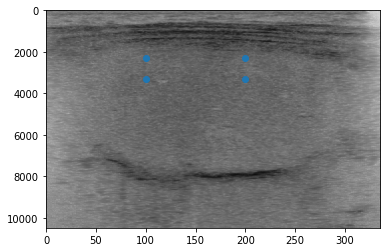

In [505]:
import matplotlib.pyplot as plt
plt.imshow(imgDataStruct.bMode, cmap='Greys', aspect='auto')
plt.scatter([x_min, x_max, x_min, x_max], [y_min, y_min, y_max, y_max])

In [500]:
window = imgDataStruct.bMode[y_min:y_max,x_min:x_max]
window_rf = imgDataStruct.rf[y_min:y_max,x_min:x_max]
window_rf_ref = refDataStruct.rf[y_min:y_max,x_min:x_max]

intensities = []
for i in range(window.shape[0]//slice_depth):
    sub_window_rf = window_rf[i*slice_depth: (i+1)*slice_depth]
    f, ps = computeHanningPowerSpec(sub_window_rf, f0, f1, fs)
    intensities.append(ps[len(f)//2])

ref_intensities = []
for i in range(window.shape[0]//slice_depth):
    sub_window_rf = window_rf_ref[i*slice_depth: (i+1)*slice_depth]
    f, ps = computeHanningPowerSpec(sub_window_rf, f0, f1, fs)
    ref_intensities.append(ps[len(f)//2])

depth_cm = np.arange(len(intensities))*slice_depth*spectralAnalysis.ultrasoundImage.axialResRf/10
p = np.polyfit(depth_cm, intensities, 1)
p_ref = np.polyfit(depth_cm, ref_intensities, 1)
y = depth_cm*p[0] + p[1]
corr = np.corrcoef(y, intensities)[0,1]
attenuationCoeff = -(p[0]-p_ref[0])/8

0.5389856202881901 0.0034383742634271288


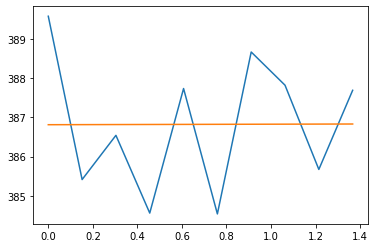

In [501]:
print(attenuationCoeff, corr)
plt.plot(depth_cm, intensities)
plt.plot(depth_cm, y)

In [424]:
import pickle
out_dir = Path.cwd() / Path("CLI-Demos/new_dict.pkl")
with open(out_dir, "rb") as f:
    out_dict = pickle.load(f)
patient_num = int(im.parents[1].name)
filename = im.name.split(".")[:-1][0]
coords = (x_min, y_min, x_max, y_max)
try:
    out_dict[patient_num]
except KeyError:
    out_dict[patient_num] = {}
out_dict[patient_num][filename] = coords

with open(out_dir, "wb") as f:
    pickle.dump(out_dict, f)

In [237]:
x_min = 75; x_max = x_min+100
y_min = 3000; y_max = y_min+2000

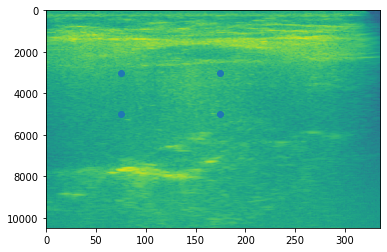

In [238]:
import matplotlib.pyplot as plt
plt.imshow(ultrasoundImage.bmode, aspect='auto')
plt.scatter([x_min, x_max, x_min, x_max], [y_min, y_min, y_max, y_max])

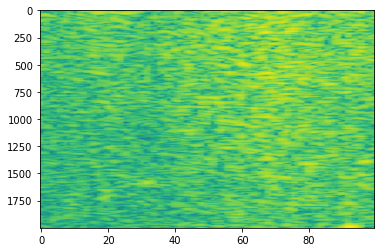

In [239]:
window = ultrasoundImage.bmode[y_min:y_max,x_min:x_max]
window_rf = ultrasoundImage.rf[y_min:y_max,x_min:x_max]
window_rf_ref = ultrasoundImage.phantomRf[y_min:y_max,x_min:x_max]
plt.imshow(window, aspect='auto')

In [252]:
window.shape
from pyQus.transforms import computeHanningPowerSpec as computeHilbertPowerSpec

In [253]:
slice_depth = 100

intensities = []
for i in range(window.shape[0]//slice_depth):
    sub_window_rf = window_rf[i*slice_depth: (i+1)*slice_depth]
    f, ps = computeHilbertPowerSpec(sub_window_rf, f0, f1, fs)
    intensities.append(ps[len(f)//2])

In [254]:
ref_intensities = []
for i in range(window.shape[0]//slice_depth):
    sub_window_rf = window_rf_ref[i*slice_depth: (i+1)*slice_depth]
    f, ps = computeHilbertPowerSpec(sub_window_rf, f0, f1, fs)
    ref_intensities.append(ps[len(f)//2])

Text(0, 0.5, 'Intensity (dB)')

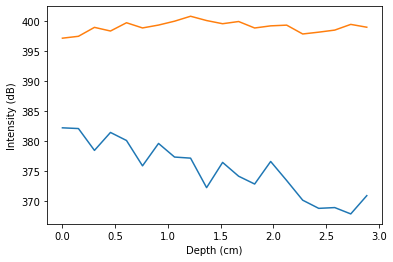

In [255]:
import numpy as np

depth_cm = np.arange(len(intensities))*slice_depth*spectralAnalysis.ultrasoundImage.axialResRf/10
plt.plot(depth_cm, intensities)
plt.plot(depth_cm, ref_intensities)
plt.xlabel("Depth (cm)")
plt.ylabel("Intensity (dB)")

In [256]:
coefs = []
for i, intensity in enumerate(intensities):
    if not i:
        continue
    p = np.polyfit(depth_cm[i-1:i+1], intensities[i-1:i+1], 1)
    p_ref = np.polyfit(depth_cm[i-1:i+1], ref_intensities[i-1:i+1], 1)
    coefs.append(-(p[0]-p_ref[0])/8)

In [257]:
np.mean(coefs)

0.5697971165115476

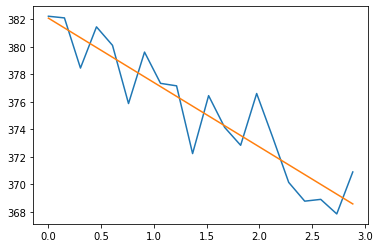

In [258]:
p = np.polyfit(depth_cm, intensities, 1)
p_ref = np.polyfit(depth_cm, ref_intensities, 1)
y = depth_cm*p[0] + p[1]
plt.plot(depth_cm, intensities)
plt.plot(depth_cm, y)

In [260]:
-(p[0]-p_ref[0])/8

0.6056499118957762

In [261]:
np.corrcoef(y, intensities)

array([[1.        , 0.91678453],
       [0.91678453, 1.        ]])

# Visualizations

In [103]:
import matplotlib.pyplot as plt

from src.DataLayer.spectral import SpectralData
from src.DataLayer.dataObjects import ScConfig

In [104]:
scConfig = ScConfig()
scConfig.width = imgInfoStruct.width1
scConfig.tilt = imgInfoStruct.tilt1
scConfig.startDepth = imgInfoStruct.startDepth1
scConfig.endDepth = imgInfoStruct.endDepth1

In [105]:
spectralData = SpectralData()
spectralData.spectralAnalysis = spectralAnalysis
spectralData.scConfig = scConfig

In [106]:
spectralData.convertImagesToRGB()

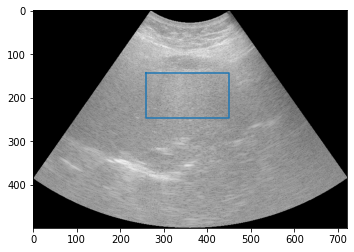

In [107]:
plt.imshow(spectralData.scBmode)
plt.plot(scSplineX, scSplineY)

In [23]:
spectralData.drawCmaps()
spectralData.scanConvertCmaps()

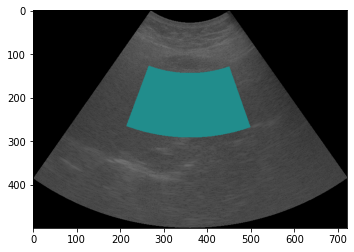

In [24]:
plt.imshow(spectralData.scMbfIm)

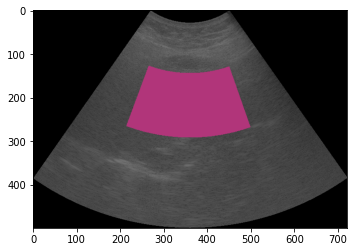

In [25]:
plt.imshow(spectralData.scSsIm)

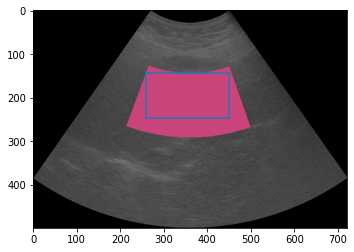

In [26]:
plt.imshow(spectralData.scSiIm)
plt.plot(spectralData.splineX, spectralData.splineY)

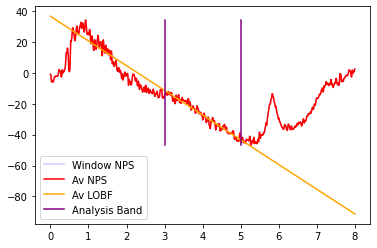

In [27]:
spectralData.plotPsData()